# compare duplicate runs 

In [263]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio import AlignIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree, toyplot
import toyplot.pdf
import toyplot.png
path = '/storage/btbgenie/all_ireland_results'

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/dup_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/duplicates/'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [5]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')

In [136]:
dups1=meta[meta.duplicated('aliquot',keep='last')].dropna()
dups2=meta[meta.duplicated('aliquot',keep='first')].dropna()
print (len(dups1),len(dups2))
#print (dups2)

17 17


## combine samples into one table

In [140]:
summ1 = pd.read_csv('/storage/btbgenie/dup_results/summary.csv')
summ2 = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/summary.csv')
summ2 = summ2[summ2['sample'].isin(dups1['sample'])]
print (len(summ1),len(summ2))
df = pd.concat([summ1,summ2])
df['pair'] = df['sample'].apply(lambda x: x[-4:])
df=df[df.pair!='4235']
df = df.sort_values('pair')

16 17


In [141]:
app.write_samples(df,'duplicate_test')

'duplicate_test/samples.txt'

In [ ]:
depths=[]
for i,r in df.iterrows():
    print (r.bam_file)
    c=tools.get_mean_depth(r.bam_file)
    depths.append(c)

In [169]:
df['depth']=depths
df.to_csv('duplicates.csv',index=False)

## call variants on paired duplicates

In [345]:
reload(app)
app.run_bamfiles(df.bam_file, app.mbovis_genome, outdir='duplicate_test', threads=20,
                 #custom_filters=True, mask=app.mbovis_mask,
                 overwrite=False)

duplicate_test/raw.bcf already exists
calling variants..
bcftools call --ploidy 1 -m -v -o duplicate_test/calls.vcf duplicate_test/raw.bcf
duplicate_test/samples.txt
bcftools reheader --samples duplicate_test/samples.txt -o /tmp/calls.vcf duplicate_test/calls.vcf
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4" -o duplicate_test/filtered.vcf.gz -O z duplicate_test/calls.vcf
splitting snps and indels..
bcftools view -v snps -o duplicate_test/snps.vcf.gz -O z duplicate_test/filtered.vcf.gz
bcftools view -v indels -o duplicate_test/indels.vcf.gz -O z duplicate_test/filtered.vcf.gz
took 17.0 seconds
found 443 sites
23 sites with at least one missing sample
76 uninformative sites
raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 21520906 -x 47681550 -n variants -w /home/farrell/gitprojects/snipgenie/notebooks/duplicate_test -s duplicate_test/core.fa


## draw tree

In [346]:
tre = toytree.tree('duplicate_test/tree.newick')
tre=tre.drop_tips(['ref','2014','TB19-002014'])
tre=tre.root('3762')
mapping = dict(zip(df['sample'],df.pair))
colormap = trees.colors_from_labels(df,'sample','pair')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tre.get_tip_labels()]
node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=1000,height=600,scalebar=True,tip_labels_colors=tip_colors)#tip_labels=False,
                    #node_colors=node_colors,node_sizes=node_sizes);
toyplot.pdf.render(canvas,'duplicate_test/tree_nofilters.pdf')


## read snps

In [347]:
sdist = pd.read_csv('duplicate_test/snpdist.csv',index_col=0)
#sdist.iloc[:10,:10]

In [348]:
dists=[]
for i,g in df.groupby('pair'):
    s1,s2 = list(g['sample'])
    dists.append((s1+'v'+s2,sdist.loc[s1,s2]))
dists=pd.DataFrame(dists,columns=['pair','snps'])
dists2=dists

In [349]:
x=dists1.merge(dists2,on='pair')[1:]
x.columns=['pair','filter','no filter']
x

,pair,filter,no filter
1,3260vTB19-003260,1,4
2,3261vTB19-003261,1,2
3,TB19-003263v3263,0,5
4,TB19-003377v3377,1,2
5,TB19-003437v3437,0,0
6,TB19-003738v3738,2,2
7,TB19-003747v3747,2,2
8,3762vTB19-003762,3,4
9,3825vTB19-003825,1,1
10,4238vTB19-004238,0,0


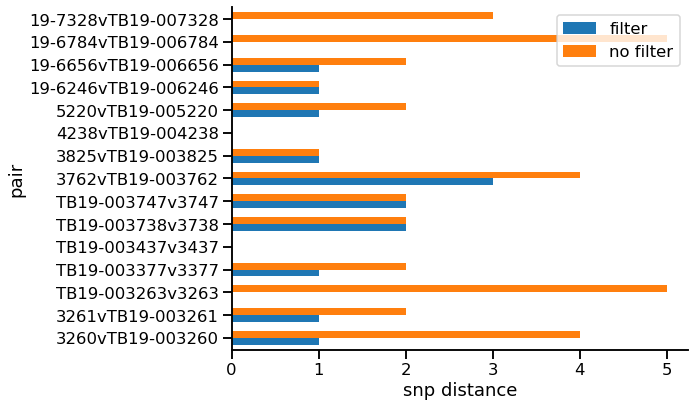

In [350]:
#sns.set_context('talk')
x.plot(x='pair',kind='barh',width=.6,figsize=(10,6))
plt.xlabel('snp distance')
sns.despine()
plt.tight_layout()
plt.savefig('snp_duplicates_dists.jpg',dpi=120)